In [41]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from nltk.corpus import stopwords,words,brown
from nltk import word_tokenize, sent_tokenize, pos_tag
from string import punctuation
import csv
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from gensim.models import Word2Vec, Doc2Vec, LdaModel
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import normalize
#import pyemd
from autocorrect import spell
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from scipy.stats import entropy
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
#import scikitplot as skplt
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter

### Loading data

In [5]:
df = pd.read_csv("training_set_rel3.csv", header = None, encoding='ISO-8859-1')

#Read in prompts
prompt_0 = []
prompt_1 = open('prompt_1.txt',encoding = 'ISO-8859-1').read()
prompt_2 = open('prompt_2.txt',encoding = 'ISO-8859-1').read()
prompt_3 = open('prompt_3.txt',encoding = 'ISO-8859-1').read()
prompt_4 = open('prompt_4.txt',encoding = 'ISO-8859-1').read()
prompt_5 = open('prompt_5.txt',encoding = 'ISO-8859-1').read()
prompt_6 = open('prompt_6.txt',encoding = 'ISO-8859-1').read()
prompt_7 = open('prompt_7.txt',encoding = 'ISO-8859-1').read()
prompt_8 = open('prompt_8.txt',encoding = 'ISO-8859-1').read()
prompts = ['',prompt_1,prompt_2,prompt_3,prompt_4,prompt_5,prompt_6,prompt_7,prompt_8]

In [6]:
df = df.loc[:, 0:2]
df.columns = ['id', 'essay_set','essay']

### Cleaning data

In [7]:
# Replace NaN values with an empty string and make sure all responses are type str
df = df.replace(np.nan, '', regex=True)
df['response']=df['essay'].astype(str)

In [8]:
df

,id,essay_set,essay,response
0,1,1,"Dear local newspaper, I think effects computer...","Dear local newspaper, I think effects computer..."
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...","Dear @CAPS1 @CAPS2, I believe that using compu..."
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...","Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl..."
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...","Dear Local Newspaper, @CAPS1 I have found that..."
4,5,1,"Dear @LOCATION1, I know having computers has a...","Dear @LOCATION1, I know having computers has a..."
5,6,1,"Dear @LOCATION1, I think that computers have a...","Dear @LOCATION1, I think that computers have a..."
6,7,1,Did you know that more and more people these d...,Did you know that more and more people these d...
7,8,1,@PERCENT1 of people agree that computers make ...,@PERCENT1 of people agree that computers make ...
8,9,1,"Dear reader, @ORGANIZATION1 has had a dramatic...","Dear reader, @ORGANIZATION1 has had a dramatic..."
9,10,1,In the @LOCATION1 we have the technology of a ...,In the @LOCATION1 we have the technology of a ...


In [9]:
#rename columns and subset
df = df[['id','essay_set' ,'response']]

In [10]:
print(df['essay_set'].value_counts())

5    1805
6    1800
2    1800
1    1783
4    1772
3    1726
7    1569
8     723
Name: essay_set, dtype: int64


In [11]:
# Define a function to count special characters
def check_for_unwanted_chars(df, input_column):
    df['double_newline'] = df[input_column].str.count('\\\\n')
    df['carriage_return'] = df[input_column].str.count('\r')
    df['permille'] = df[input_column].str.count('‰')
    df['isnull'] = pd.isnull(df[input_column])
    print(df[['double_newline', 'permille', 'isnull', 'carriage_return']].sum())

In [12]:
# Check for special characters
check_for_unwanted_chars(df.copy(), 'response')

double_newline     0.0
permille           0.0
isnull             0.0
carriage_return    0.0
dtype: float64


In [13]:
# Perform appropriate replacement for any quirks found. 
df['response'].replace('\\\\n','\n', inplace=True, regex=True)

# Reruns the unwanted characters check. All values should be zero if replacement was successful.
check_for_unwanted_chars(df.copy(), 'response')

double_newline     0.0
permille           0.0
isnull             0.0
carriage_return    0.0
dtype: float64


C:\Users\Abhishek\Anaconda3\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


### Adding shuffled prompts

In [14]:
df_prompts = df[['essay_set']].copy()
df_prompts.columns = ['shuffled']
df_prompts = df_prompts.sample(frac=1, random_state = 2)
df_prompts = df_prompts.reset_index()
df = df.reset_index()
df_prepared = pd.concat([df, df_prompts], axis=1, ignore_index=True)
df_prepared.columns = ['no','id','actual_set','response','index','shuffled_set']
#df_prepared.rename({1:'id', 2:'actual_set',3:'response',4:'index',5:'shuffled_set'}, inplace=True)
df_prepared = df_prepared.drop(labels=['no','index'],axis=1)

In [15]:
df_prepared.head(10)

,id,actual_set,response,shuffled_set
0,1,1,"Dear local newspaper, I think effects computer...",3
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",1
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",2
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",4
4,5,1,"Dear @LOCATION1, I know having computers has a...",2
5,6,1,"Dear @LOCATION1, I think that computers have a...",2
6,7,1,Did you know that more and more people these d...,1
7,8,1,@PERCENT1 of people agree that computers make ...,1
8,9,1,"Dear reader, @ORGANIZATION1 has had a dramatic...",6
9,10,1,In the @LOCATION1 we have the technology of a ...,2


### Adding off-topic flag and splitting data into train and test

In [16]:
#Off-topic flag
def off_topic(row):
    if row['actual_set'] != row['shuffled_set']:
        return True
    else:
        return False
    
df_prepared['off_topic'] = df_prepared.apply(lambda row: off_topic(row),axis=1)

Altering ratio of True to False samples by reducing the number of True samples

In [17]:
df_false = df_prepared[df_prepared['off_topic'] == False]
df_true = df_prepared[df_prepared['off_topic'] == True].sample(frac=0.007, random_state = 2)
df_reduced = df_true.append(df_false)

Choice of input

In [18]:
#df_input = df_prepared

df_input = df_reduced

In [19]:
#Split into train and test
df_train, df_test = train_test_split(df_input, test_size=0.2, random_state=2)
df_train['global_index'] = range(0, len(df_train))

C:\Users\Abhishek\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
df_train

,id,actual_set,response,shuffled_set,off_topic,global_index
3239,4434,2,I do not believe that these types of books sho...,2,False,0
1380,1385,1,Did you know that in a recent poll in the @CAP...,1,False,1
3754,6150,3,"In the story, Do Not Exceed Posted Speed Limit...",3,False,2
8984,14932,6,The builders of the Empire State building face...,6,False,3
1887,3082,2,NEWSPAPER @CAPS1 today im going to tell yo...,5,True,4
4773,7171,3,When the bicyclist was trying to find Yosemite...,3,False,5
3076,4271,2,My views on censorship are strong. I think tha...,2,False,6
6612,10171,4,The author concludes the story with the paragr...,4,False,7
5788,9343,4,The author concludes this story with this para...,4,False,8
12201,19505,7,Patience is something is most people don?t hav...,7,False,9


### Creating corpus of documents comprising of prompts and responses in training set

#### Choice of corpus

With prompts, for extracting similarity scores as features

In [21]:
response_list = list(df_train['response'])
collection = []
collection.extend(prompts)
collection.extend(response_list)

Without prompts, for extracting LSA vectors as features

In [18]:
# response_list = list(df_train['response'])
# collection = []
# collection.extend(response_list)

### Creating tf-idf, LSA and LDA matrices

In [19]:
def preprocessing_step(string):    
    tokens = simple_preprocess(string)

    def get_wordnet_pos(treebank_tag):

        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None # for easy if-statement

    lemmas = []
    lemmatizer = WordNetLemmatizer()
    tagged = nltk.pos_tag(tokens)
    for word, tag in tagged:
        wntag = get_wordnet_pos(tag)
        if wntag is None:# not supply tag in case of None
            lemma = lemmatizer.lemmatize(word) 
        else:
            lemma = lemmatizer.lemmatize(word, pos=wntag)
        lemmas.append(lemma)

    return lemmas

In [20]:
#Create tf-idf matrix
tfidf_vectorizer = TfidfVectorizer(min_df = 1, ngram_range=(1, 3), stop_words = 'english', analyzer = 'word', tokenizer = preprocessing_step, preprocessor = None)
lsa = TruncatedSVD(15, algorithm = 'arpack')
dtm = tfidf_vectorizer.fit_transform(collection)
similarities = (dtm * dtm.T).A #Similarity matrix for tf-idf similarity

In [21]:
#Create normalized LSA matrix
dtm_float = dtm.astype(float)
dtm_lsa = lsa.fit_transform(dtm_float)
Normalizer_dtm_lsa = Normalizer(copy=False)
dtm_lsa = Normalizer_dtm_lsa.fit_transform(dtm_lsa)

In [22]:
#Create LDA matrix
NUM_TOPICS = 25
preprocessed_collection = []
for item in collection:
    preprocessed_collection.append(simple_preprocess(item))
dictionary = Dictionary(preprocessed_collection)
corpus = [dictionary.doc2bow(text) for text in preprocessed_collection]
lda = LdaModel(corpus, num_topics=NUM_TOPICS)
topic_dist_array = np.zeros((len(collection), NUM_TOPICS))
for index, lst in enumerate(lda[corpus]):
    for tup in lst:
        topic_dist_array[index][tup[0]] = tup[1]

In [23]:
#Function for LDA Jenson-Shannon Divergence
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query.T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

### Doc2Vec model training

In [24]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(collection)]
max_epochs = 120
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

d2vmodel = Doc2Vec.load("d2v.model")

/usr/local/lib64/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [25]:
#Create normalized matrix of Doc2Vec vectors to compare against unseen responses in test data
model_matrix = []
for i in range (0,len(collection)):
    model_matrix.append(np.asarray(d2vmodel.docvecs[i]))

normed_matrix = normalize(model_matrix, axis=1, norm='l2')

### Word2Vec model training for WMD similarity

In [26]:
processed_responses = []

for response in response_list:
    processed_responses.append(simple_preprocess(response))

model = Word2Vec(
        processed_responses,
        size=150,
        window=3,
        min_count=2,
        workers=10)

model.train(processed_responses, total_examples=len(processed_responses), epochs=10)

model.init_sims(replace=True) 

model.save("w2v.model")

w2vmodel = Word2Vec.load("w2v.model")

### Functions for feature and class generation

In [33]:
def featurizer(df_prepared,prompts, dtm_lsa, tfidf_vectorizer, lsa, train_BOOL, d2vmodel, w2vmodel, normed_matrix, similarities, dtm, topic_dist_array, dictionary):    
    
    features = []
    
    scaler = StandardScaler()
    
    i = 0
    for index, row in df_prepared.iterrows():
        feature_dictionary = {}

        
#         #TF-IDF SIMILARITY FEATURE
#         if train_BOOL == True:
#             feature_dictionary['tf_idf_sim'] = similarities[row['shuffled_set']][row['global_index']+9]
            
#         if train_BOOL == False:
#             dtm2 = tfidf_vectorizer.transform([row['response']])
#             feature_dictionary['tf_idf_sim'] = (dtm[row['shuffled_set']]*dtm2.T).A[0][0]
    
        #LSA SIMILARITY FEATURE        
        if train_BOOL == True:
            feature_dictionary['lsa_sim'] = np.dot(np.asarray(dtm_lsa[row['shuffled_set']]),np.asarray(dtm_lsa[row['global_index']+9]))

        if train_BOOL == False:
            dtm2 = tfidf_vectorizer.transform([row['response']])
            dtm2_float = dtm2.astype(float)
            dtm2_lsa = lsa.transform(dtm2_float)
            dtm2_lsa = Normalizer_dtm_lsa.transform(dtm2_lsa)
            feature_dictionary['lsa_sim'] = np.dot(np.asarray(dtm_lsa[row['shuffled_set']]),np.asarray(dtm2_lsa[0]))

#         #LDA SIMILARITY FEATURE
#         if train_BOOL == True:
#             feature_dictionary['lda_sim'] = jensen_shannon(topic_dist_array[row['shuffled_set']],topic_dist_array[row['global_index']+9])
            
#         if train_BOOL == False:
#             preprocessed = simple_preprocess(row['response'])
#             doc_bow = dictionary.doc2bow(preprocessed)
#             doc_lda = lda[doc_bow]
#             doc_lda_arr = np.zeros(NUM_TOPICS)
#             for tup in doc_lda:
#                 doc_lda_arr[tup[0]] = tup[1]
#             feature_dictionary['lda_sim'] = jensen_shannon(topic_dist_array[row['shuffled_set']],doc_lda_arr)
            

#         #DOC2VEC SIMILARITY FEATURE
#         if train_BOOL == True:
#             feature_dictionary['d2v_sim'] = d2vmodel.docvecs.similarity(row['global_index']+9,row['shuffled_set'])        
            
#         if train_BOOL == False:
#             test_data = word_tokenize(row['response'].lower())
#             v1 = d2vmodel.infer_vector(test_data)
#             v1 = v1.reshape(1,-1)
#             v1_normed = normalize(v1, axis=1, norm='l2')
#             feature_dictionary['d2v_sim'] = np.dot(np.asarray(v1_normed),np.asarray(normed_matrix[row['shuffled_set']]))
        

#         #WMD SIMILARITY FEATURE
#         wmd_sim = w2vmodel.wv.wmdistance(simple_preprocess(prompts[row['shuffled_set']]), simple_preprocess(row['response']))
#         feature_dictionary['wmd_sim'] = wmd_sim
#         print(i)
        
        #APPEND FEATURE DICTIONARY
        features.append(feature_dictionary)
        i += 1

#     #STANDARD SCALING OF WMD SIMILARITIES
#     wmd_sim_list = []
    
#     for item in features:
#         wmd_sim_list.append(item['wmd_sim'])
    
#     wmd_sim_array = np.asarray(wmd_sim_list).reshape(-1,1)
    
#     scaled_wmd_sim = scaler.fit_transform(wmd_sim_array)
    
#     j = 0
#     for sim in scaled_wmd_sim:
#         features[j]['wmd_sim'] = sim[0]
#         j += 1

    return features

def classizer(df_prepared):
    classes = []
    
    for index, row in df_prepared.iterrows():
        classes.append(row['off_topic'])
    
#     #flipping to on-topic Boolean flag for sanity check
#     for index, row in df_prepared.iterrows():
#         on_topic = not row['off_topic']
#         classes.append(on_topic)
    
    return classes

### Generating features and classes for training data

In [34]:
dict_vectorizer = DictVectorizer(sparse = True)

train_BOOL = True

classes_train = classizer(df_train)

For extracting similarity scores as features

In [29]:
features_train = dict_vectorizer.fit_transform(featurizer(df_train,prompts, dtm_lsa, tfidf_vectorizer, lsa, train_BOOL, d2vmodel, w2vmodel, normed_matrix, similarities, dtm, topic_dist_array, dictionary)) #vectorizing feature dictionary

For extracting LSA vectors as features

In [30]:
#features_train = dtm_lsa

### Training

In [31]:
#CHOOSE ONE ALGORITHM

#Grid search for SVC
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'kernel':('linear', 'rbf'), 'C': Cs, 'gamma' : gammas}
classifier = GridSearchCV(svm.SVC(random_state=2,probability = True), param_grid, cv=5)
classifier.fit(features_train,classes_train)
print(classifier.best_params_)

# #SVC
# classifier = svm.SVC(random_state=2, kernel = 'rbf', C = 1, gamma = 1, probability = True)
# classifier.fit(features_train,classes_train)

# #Gradient Boosting
# classifier = GradientBoostingClassifier()
# classifier.fit(features_train,classes_train)

{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}


### Extracting test data features

For extracting similarity scores as features

In [32]:
train_BOOL = False

features_test = dict_vectorizer.transform(featurizer(df_test,prompts, dtm_lsa, tfidf_vectorizer, lsa, train_BOOL, d2vmodel, w2vmodel, normed_matrix, similarities, dtm, topic_dist_array, dictionary))

For extracting LSA vectors as features

In [33]:
# dtm2 = tfidf_vectorizer.transform(list(df_test['response']))
# dtm2_float = dtm2.astype(float)
# dtm2_lsa = lsa.transform(dtm2_float)
# Normalizer_dtm2_lsa = Normalizer(copy=False)
# dtm2_lsa = Normalizer_dtm2_lsa.fit_transform(dtm2_lsa)

# features_test = dtm2_lsa

### Evaluation

In [46]:
classes_test = classizer(df_test)

In [34]:
train_BOOL = False

classes_test = classizer(df_test)

predicted_classes = classifier.predict(features_test) #predicting classes for test set

acc = accuracy_score(classes_test, predicted_classes)*100 #accuracy of predicted classes

mathcorr = matthews_corrcoef(classes_test, predicted_classes)

print('The accuracy of this classifier is ' + str(("%.2f" % acc)) + '%.')

print('The Matthews correlation coefficient is ' + str("%.2f" % mathcorr) + '.')

print('The precision, recall and f1 score are:')

print(precision_recall_fscore_support(classes_test, predicted_classes, average = 'macro'))

The accuracy of this classifier is 98.57%.
The Matthews correlation coefficient is 0.81.
The precision, recall and f1 score are:
(0.9524161735700197, 0.8651741293532338, 0.9036926971548072, None)


### Confusion matrix

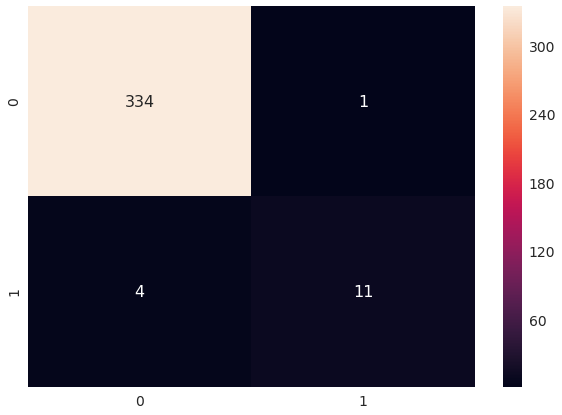

In [35]:
array = confusion_matrix(classes_test,list(predicted_classes))      
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')#font size
plt.show()